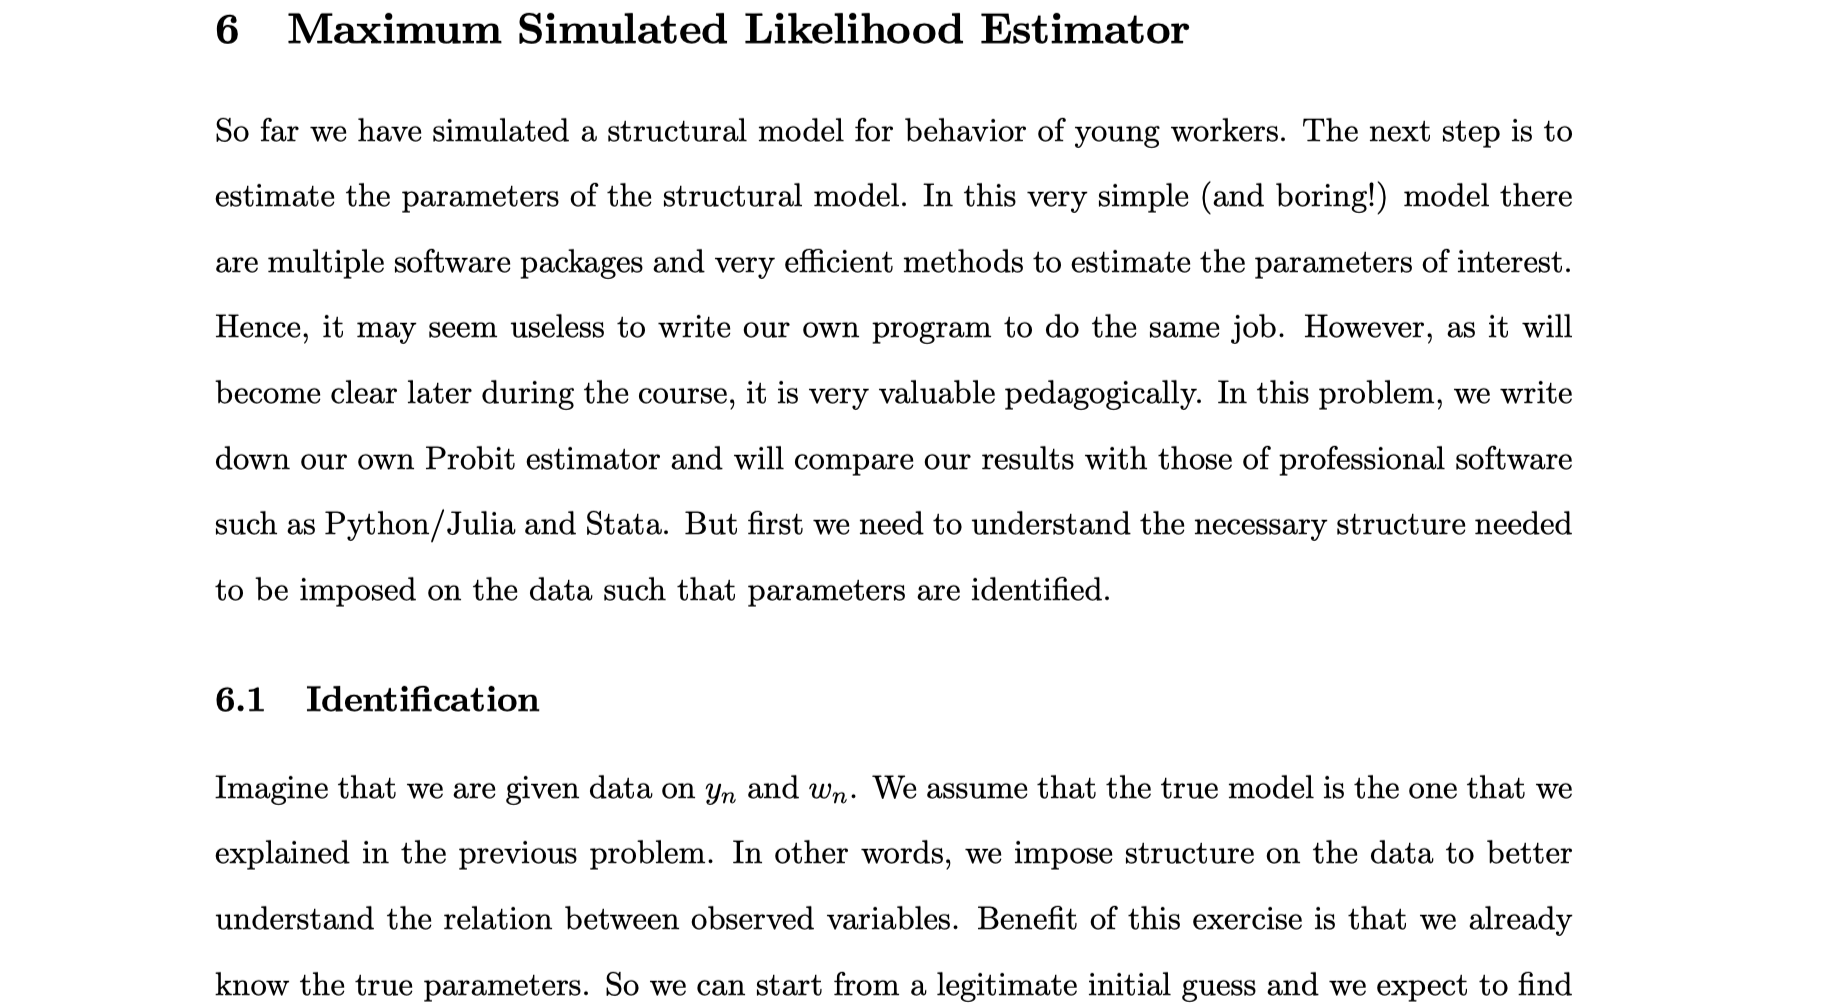
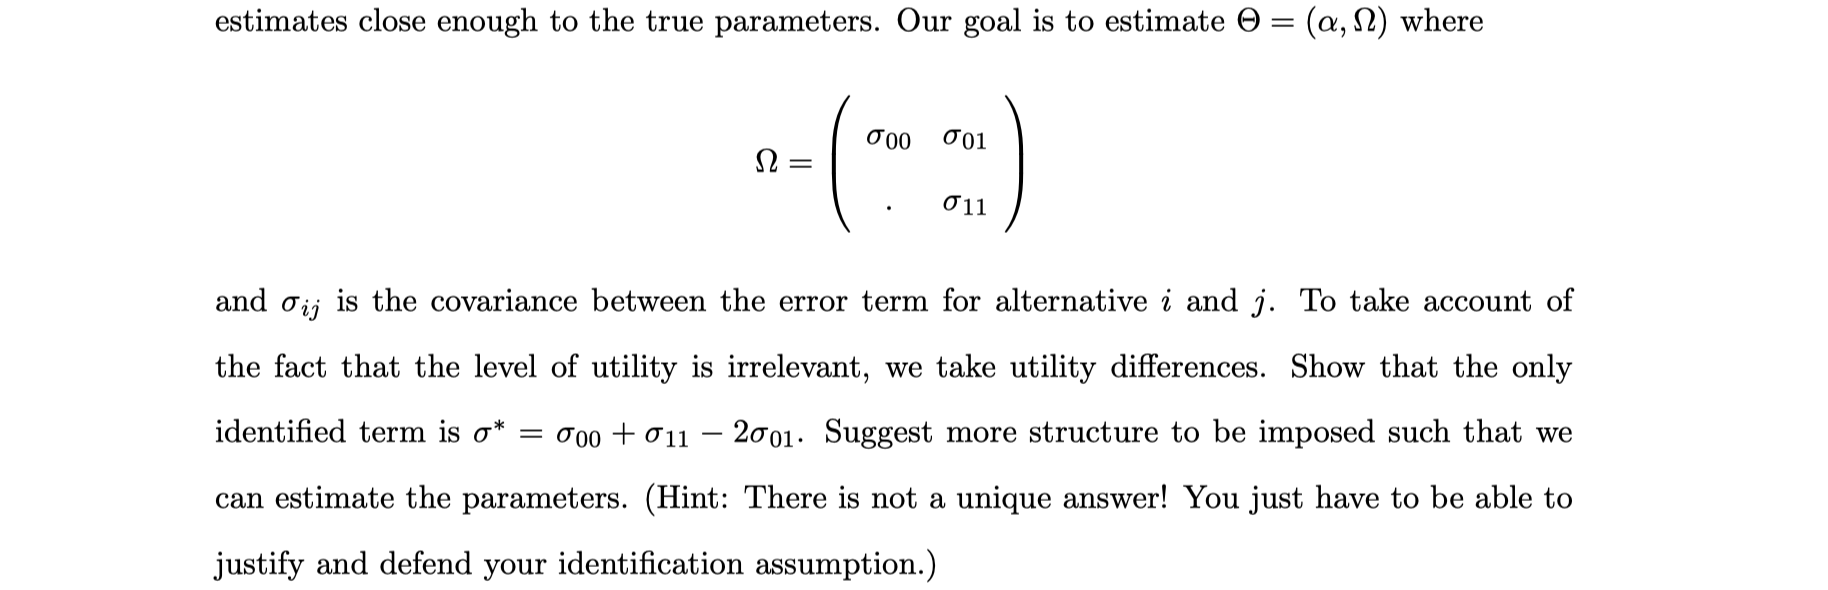

Since only differences in utility matter, the choice probabilities can be expressed as integrals over the differences between the errors. Then the variance can be derived as follows:

$Var(\epsilon_{n1}-\epsilon_{n0}) = Var(\epsilon_{n1})+Var(\epsilon_{n0})-2Cov(\epsilon_{n1},\epsilon_{n0}) = \sigma_{00}+\sigma_{11}-2\sigma_{01}=\sigma^{*}$

As described in Section 2.5 of Train(2009), any discrete choice model must be normalized to take account of the fact that the level and scale of utility are irrelevant. With probit models, normalization for scale and level does not occur automatically. The researcher must normalize the model directly. To set the scale of utility, $\sigma^{*}$ can be set to 1. Therefore, none of $\sigma_{ij}$ are identifiable.

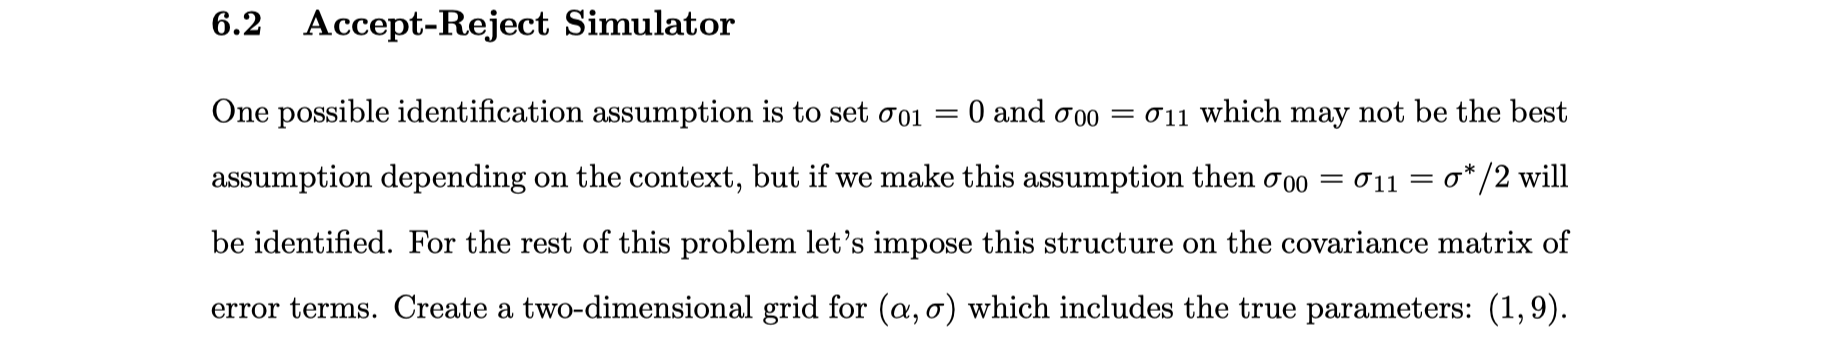

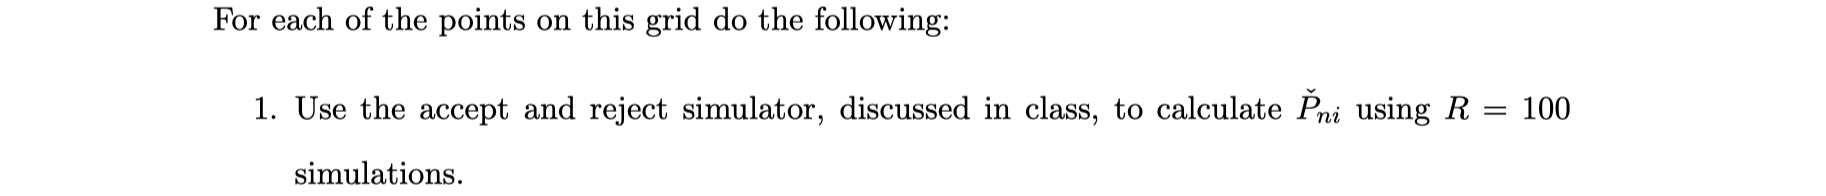

In [1]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
M = 2
z = 12
h = 1  # Shirkhodaee

In [2]:
def data_generator(N):
    sigma = 3  # σ
    alpha = 1
    np.random.seed(1395)
    epsilon = np.random.normal(0, sigma, (N, M))
    wage_offers = np.random.exponential(1 / 0.2, size=(N, 1))

    I = np.hstack([np.ones((N, 1)) * z, wage_offers * h])
    U = alpha * I + 0 + epsilon
    accept = (U[:, 1] > U[:, 0]).reshape(1, N) * 1
    return accept, wage_offers

In [3]:
def simulated_p_AR(theta, wage_offers, R, N):
    alpha, sigma = theta[0], theta[1]
    # epsilon = np.random.normal(0, sigma, (2, N, R))
    # IMPORTANT: this change, decreased execution time by more than 98 precent!
    epsilon = sigma * RANDOM_NORMAL_1
    epsilon1, epsilon2 = epsilon[0], epsilon[1]
    decision = ((alpha * wage_offers * h + epsilon1) > (alpha * z + epsilon2))
    result = decision.mean(axis=-1).reshape(N, 1)
    return result

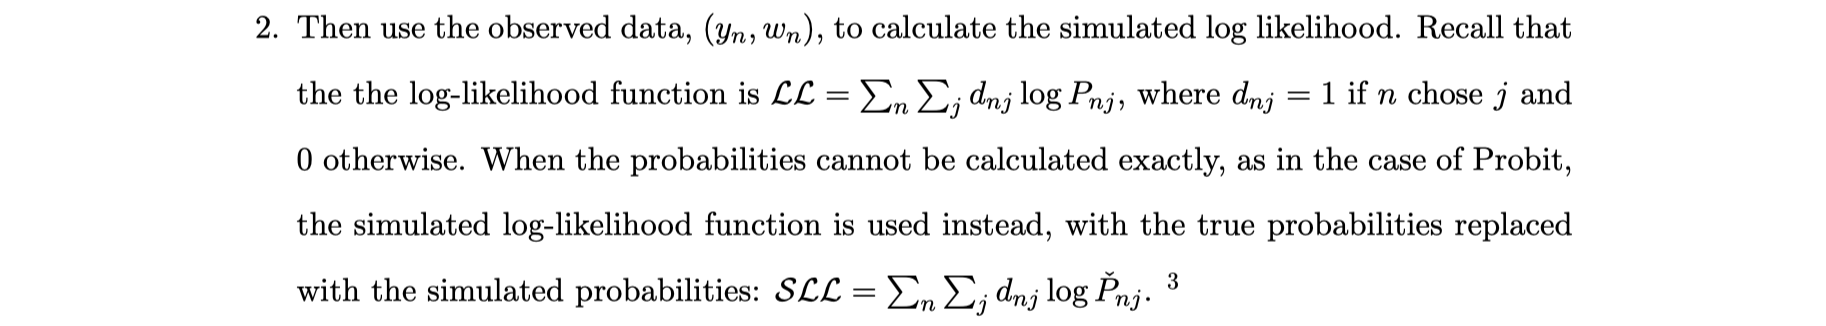
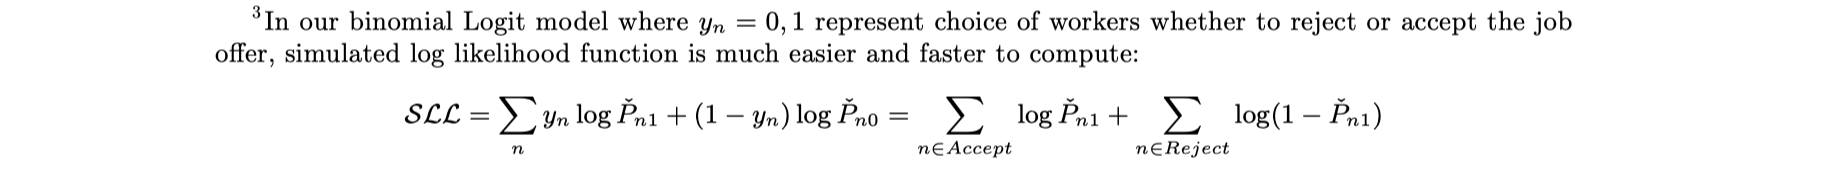

In [4]:
def MSLE(theta, accept, wage_offers, R, N):
    sp = simulated_p_AR(theta, wage_offers, R, N)
    sp = np.where(sp == 0, 1e-9, sp)
    sp = np.where(sp == 1, 1 - 1e-9, sp)
    return - (accept @ np.log(sp) + (1 - accept) @ np.log(1-sp)).item()

# In binary normal, we don't need simulation!
def MLE(theta, accept, wage_offers, R, N):
    alpha, sigma = theta[0], theta[1]
    T = alpha * (wage_offers * h - z)
    T[T < -20] = -10
    T[T > 20] = 10
    T = T / (sigma * 2**0.5) # IMPORTANT
    p = norm.cdf(T)
    ll = - (accept @ np.log(p) + (1 - accept) @ np.log(1 - p)).item()
    return ll

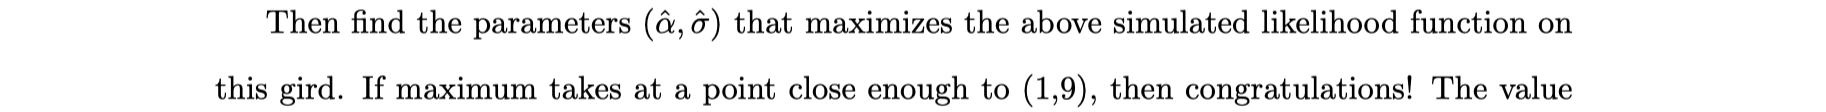
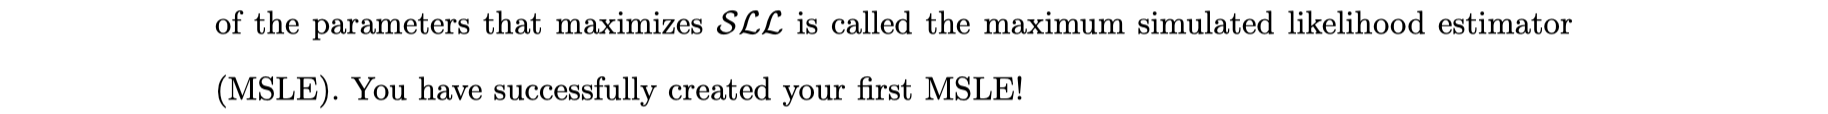

In [5]:
%%time
R, N = 1_000, 20_000
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(2, N, R))
accept, wage_offers = data_generator(N)

CPU times: user 940 ms, sys: 66.1 ms, total: 1.01 s
Wall time: 1.01 s


In [6]:
%%time
theta0 = np.array([1.1, 3.0])
result = minimize(MSLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(0, 2), (3.0, 3.0)] , method='Nelder-Mead')
print(f'MSLE: {result.x}')

MSLE: [0.97618958 3.        ]
CPU times: user 39.9 s, sys: 23 s, total: 1min 2s
Wall time: 20.9 s


In [7]:
%%time
theta0 = np.array([1.2, 3.0])

result = minimize(MLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(0, 2), (3.0, 3.0)] , method='Nelder-Mead')
print(f'MLE: {result.x}')

MLE: [0.99345703 3.        ]
CPU times: user 246 ms, sys: 139 ms, total: 385 ms
Wall time: 52.4 ms


- Both MLE estimate (0.993) and MSLE estimate (1.045) are near the true parameter (1.0)

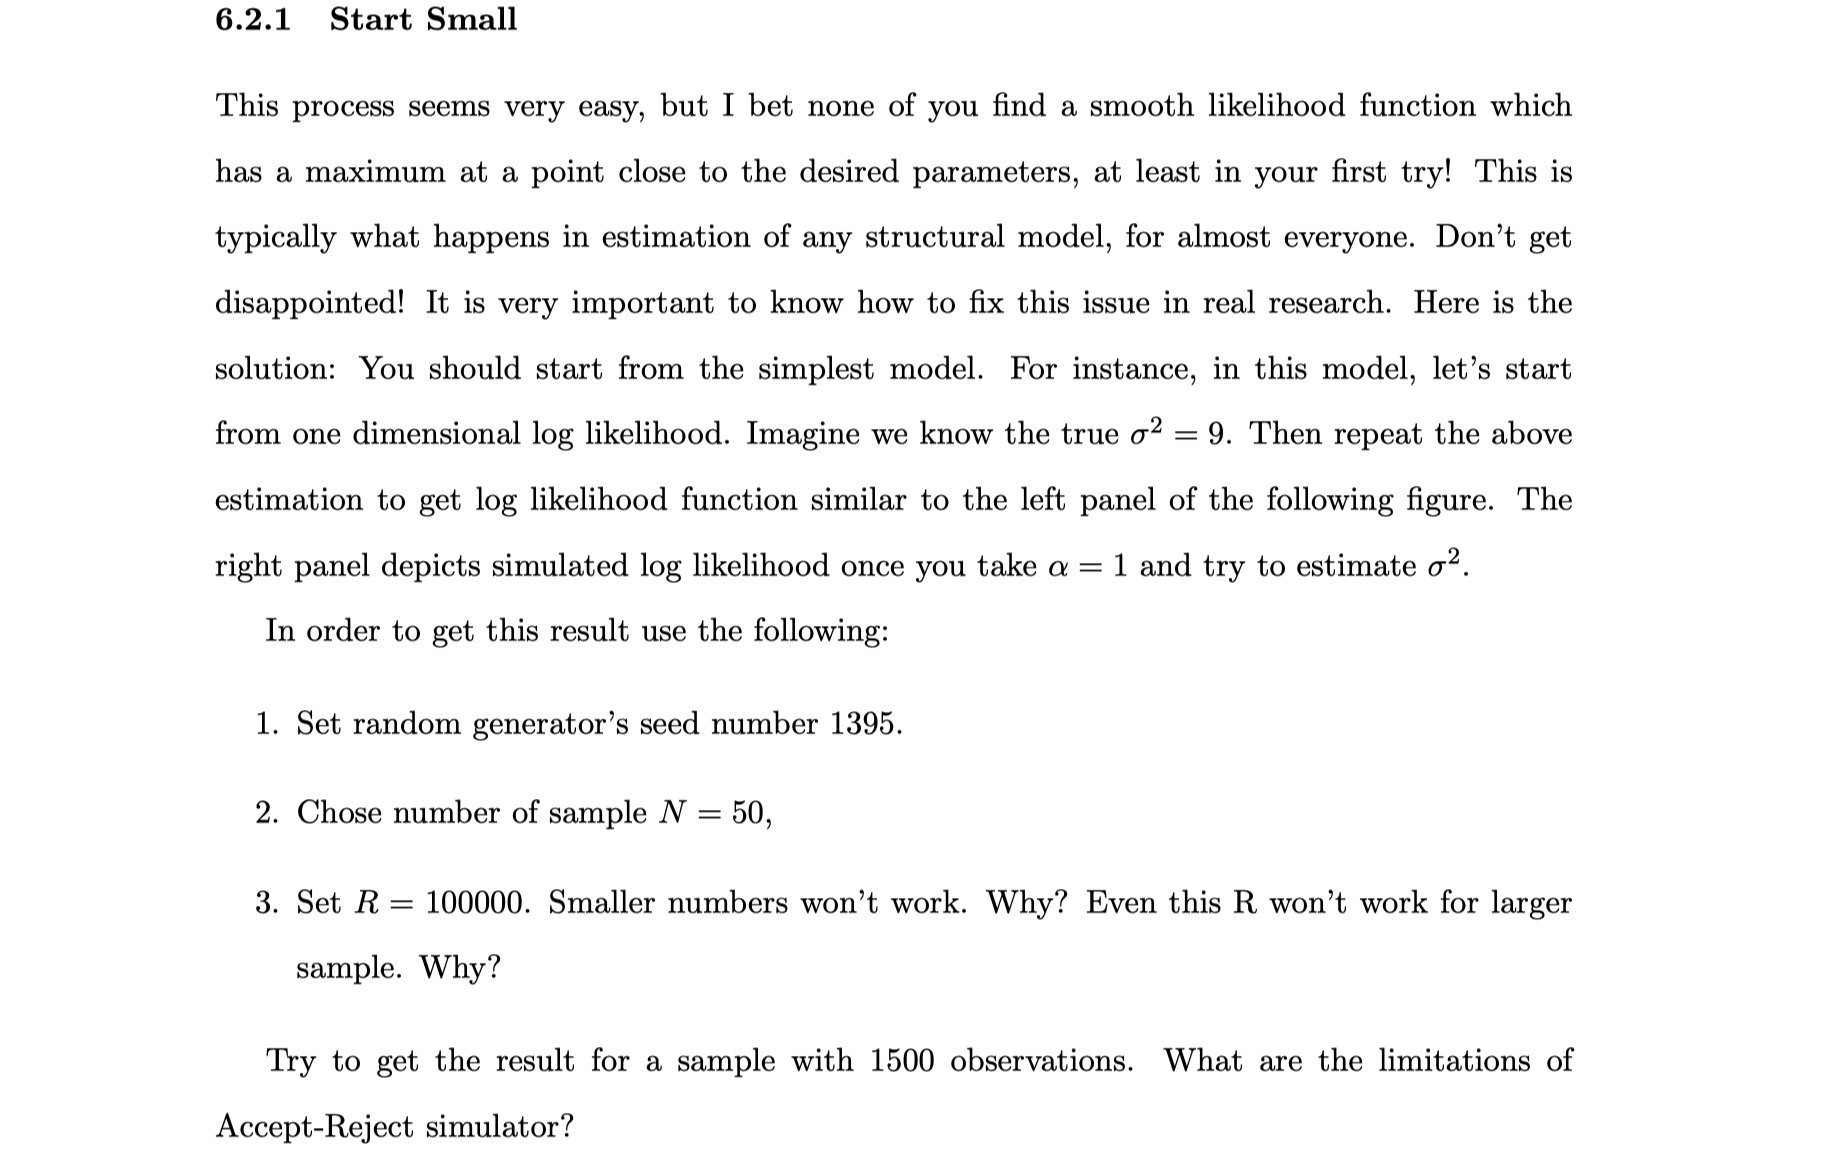

In [8]:
%%time
theta0 = np.array([0.9,3])
R, N = 1_000, 50
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(N, R))
accept, wage_offers = data_generator(N)
result = minimize(MSLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(0, 2), (3, 3)] , method='Nelder-Mead')
theta_msle = result.x
print("estimated alpha:     ", theta_msle[0])

estimated alpha:      1.3443749999999983
CPU times: user 20.5 ms, sys: 24.8 ms, total: 45.3 ms
Wall time: 45.6 ms


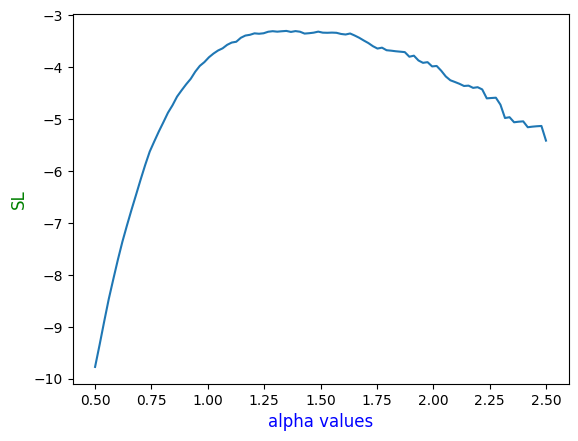

In [9]:
sigma = 3
alphas = np.linspace(0.5, 2.5, 100) 
theta_values = np.column_stack((alphas, np.full(alphas.shape, sigma)))
msle_values = [MSLE(theta_values[i], accept, wage_offers, R, N) for i in range(theta_values.shape[0])]
plt.plot(alphas,-np.array(msle_values))
plt.xlabel('alpha values', fontsize=12, color='blue')  
plt.ylabel('SL', fontsize=12, color='green') 
plt.show()

In [11]:
%%time
theta0 = np.array([0.9,3])
R, N = 1_000, 15_000
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(2, N, R))
accept, wage_offers = data_generator(N)
result = minimize(MSLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(0, 2), (3, 3)] , method='Nelder-Mead')
theta_msle = result.x
print("estimated alpha:     ", theta_msle[0])

estimated alpha:      0.9820115661621094
CPU times: user 40.3 s, sys: 19.4 s, total: 59.7 s
Wall time: 13.5 s


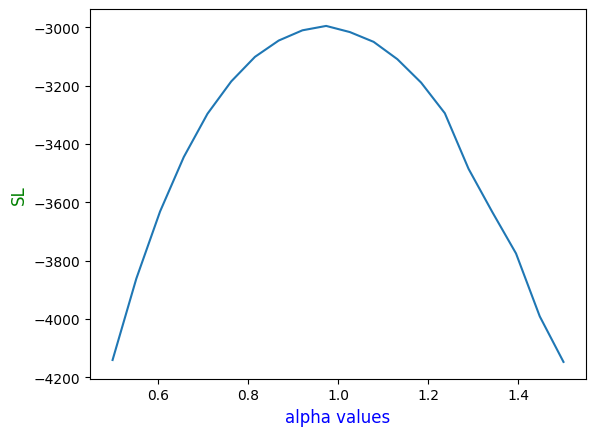

In [12]:
sigma = 3
alphas = np.linspace(0.5, 1.5, 20) 
theta_values = np.column_stack((alphas, np.full(alphas.shape, sigma)))
msle_values = [MSLE(theta_values[i], accept, wage_offers, R, N) for i in range(theta_values.shape[0])]
plt.plot(alphas,-np.array(msle_values))
plt.xlabel('alpha values', fontsize=12, color='blue')  
plt.ylabel('SL', fontsize=12, color='green') 
plt.show()

In [13]:
%%time
theta0 = np.array([1,3.1])
R, N = 1_000, 500
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(2, N, R))
accept, wage_offers = data_generator(N)
result = minimize(MSLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(1, 1), (1, 4)] , method='Nelder-Mead')
theta_msle = result.x
print("estimated sigma:     ", theta_msle[1])

estimated sigma:      2.9981298828125
CPU times: user 163 ms, sys: 65.9 ms, total: 229 ms
Wall time: 227 ms


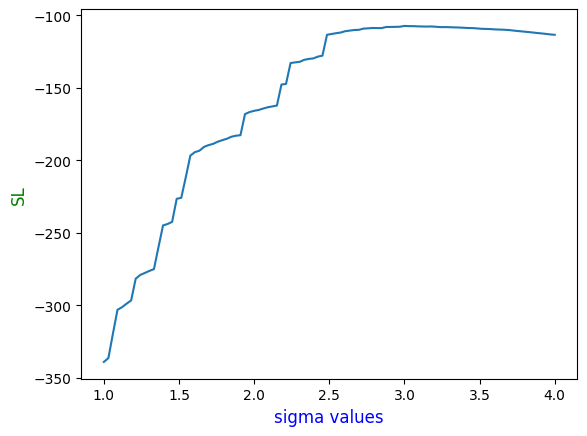

In [14]:
alpha = 1
sigmas = np.linspace(1, 4, 100) 
theta_values = np.column_stack((np.full(sigmas.shape, alpha), sigmas))
msle_values = [MSLE(theta_values[i], accept, wage_offers, R, N) for i in range(theta_values.shape[0])]
plt.plot(sigmas,-np.array(msle_values))
plt.xlabel('sigma values', fontsize=12, color='blue')  
plt.ylabel('SL', fontsize=12, color='green') 
plt.show()

In [15]:
%%time
theta0 = np.array([1,3])
R, N = 1000, 1500
RANDOM_NORMAL_1 = np.random.normal(0, 1, size=(2, N, R))
accept, wage_offers = data_generator(N)
result = minimize(MSLE, theta0, args=(accept, wage_offers, R, N),
                  bounds = [(1, 1), (2, 4)] , method='Nelder-Mead')
theta_msle = result.x
print("estimated sigma:     ", theta_msle[1])

estimated sigma:      3.1747192382812504
CPU times: user 594 ms, sys: 154 ms, total: 747 ms
Wall time: 746 ms


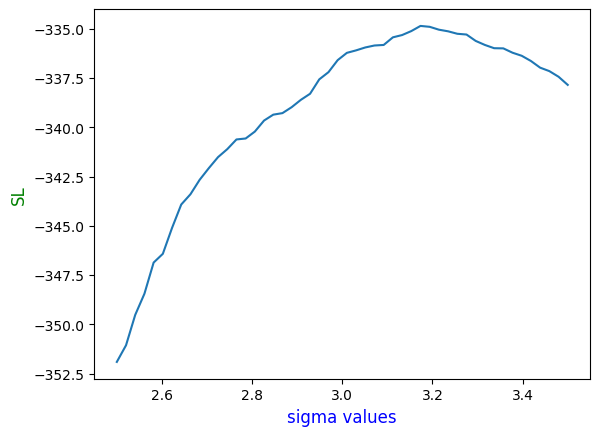

In [16]:
alpha = 1
sigmas = np.linspace(2.5, 3.5, 50) 
theta_values = np.column_stack((np.full(sigmas.shape, alpha), sigmas))
msle_values = [MSLE(theta_values[i], accept, wage_offers, R, N) for i in range(theta_values.shape[0])]
plt.plot(sigmas,-np.array(msle_values))
plt.xlabel('sigma values', fontsize=12, color='blue')  
plt.ylabel('SL', fontsize=12, color='green') 
plt.show()

Set R = 100000. Smaller numbers won’t work. Why? Even this R won’t work for larger sample. Why?

A larger R provides a more reliable estimate of the true integral by the Law of Large Numbers, and will tend to become closer as more trials are performed. Also, More iterations help in reducing the variance of the estimator, and ensures accuracy. For larger samples, R = 100000 may not suffice because the total number of accepted draws may not be adequate to accurately estimate the integral across all observations, particularly if the acceptance rate is low. 

Limitations of AR-simulator:
The simulated probabilities are not smooth in the parameters.
As R or N increase, the simulation gets super slow.
The efficiency of an accept-reject algorithm is largely dependent on the acceptance rate.
There might be zero probabilities, and log(0) = -inf, in order to handle this i replaced these probabilities with very small values near zero. (Correct way to handle this is to use Smoothed AR simulator which is implemented in part 6.3)




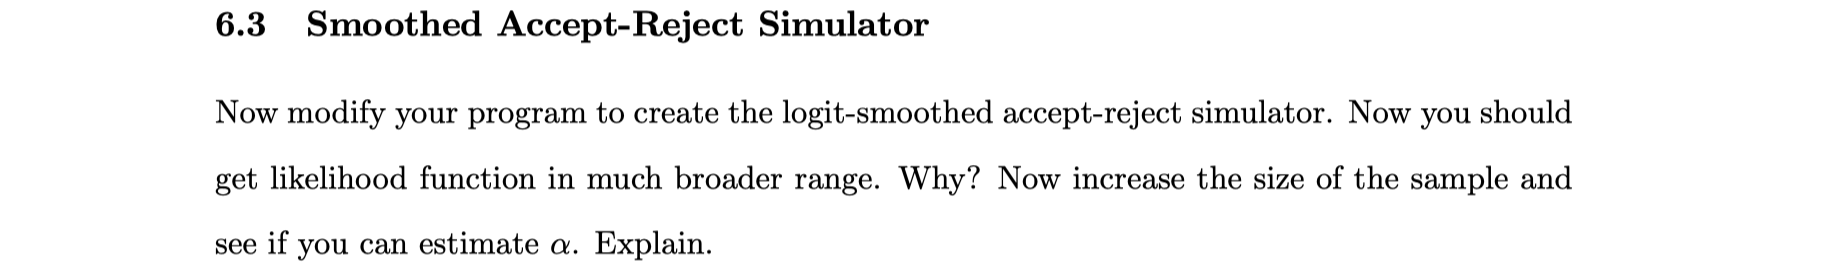

In [17]:
def data_generator_modified(N):
    sigma = 3  # σ
    alpha = 1
    np.random.seed(1395)
    epsilon = np.random.normal(0, sigma, (N, M))
    wage_offers = np.random.exponential(1 / 0.2, size=(N, 1))

    I = np.hstack([np.ones((N, 1)) * z, wage_offers * h])
    U = alpha * I + 0 + epsilon
    accept = (U[:, 1] > U[:, 0]).reshape(1,N)*1
    return accept, wage_offers

In [18]:
def simulated_p_AR_modified(theta, wage_offers, R, N, landa):
    alpha, sigma = theta[0], theta[1]
    # epsilon = np.random.normal(0, sigma, (2, N, R))
    # IMPORTANT: this change, decreased execution time by more than 98 precent!
    epsilon = sigma * RANDOM_NORMAL_2
    epsilon1, epsilon2 = epsilon[0], epsilon[1]
    U_accept = (alpha * wage_offers * h + epsilon1)
    U_reject = (alpha * z + epsilon2)
    sm = np.exp(U_accept/landa)/(np.exp(U_accept/landa)+np.exp(U_reject/landa))
    result = sm.mean(axis=-1).reshape(N, 1)
    return result

In [19]:
def MSLE_modified(theta, accept, wage_offers, R, N, landa):
    sp = simulated_p_AR_modified(theta, wage_offers, R, N, landa)
    return - (accept @ np.log(sp) + (1-accept) @ np.log(1-sp)).item()

In [20]:
%%time
theta0 = np.array([1.1, 3])
R, N, landa = 1000, 1500, 1
RANDOM_NORMAL_2 = np.random.normal(0, 1, size=(2, N, R))
accept, wage_offers = data_generator_modified(N)
result = minimize(MSLE_modified, theta0, args=(accept, wage_offers, R, N, landa),
                  bounds = [(0, 2), (3, 3)] , method='Nelder-Mead')
theta_msle = result.x
print("estimated alpha:     ", theta_msle[0])

estimated alpha:      1.035546875
CPU times: user 1.46 s, sys: 213 ms, total: 1.67 s
Wall time: 1.67 s


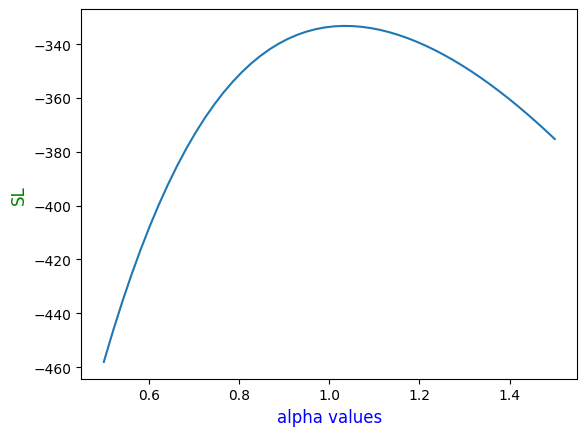

In [21]:
sigma = 3
alphas = np.linspace(0.5, 1.5, 50) 
theta_values = np.column_stack((alphas, np.full(alphas.shape, sigma)))
msle_values = [MSLE_modified(theta_values[i], accept, wage_offers, R, N, landa) for i in range(theta_values.shape[0])]
plt.plot(alphas,-np.array(msle_values))
plt.xlabel('alpha values', fontsize=12, color='blue')  
plt.ylabel('SL', fontsize=12, color='green') 
plt.show()